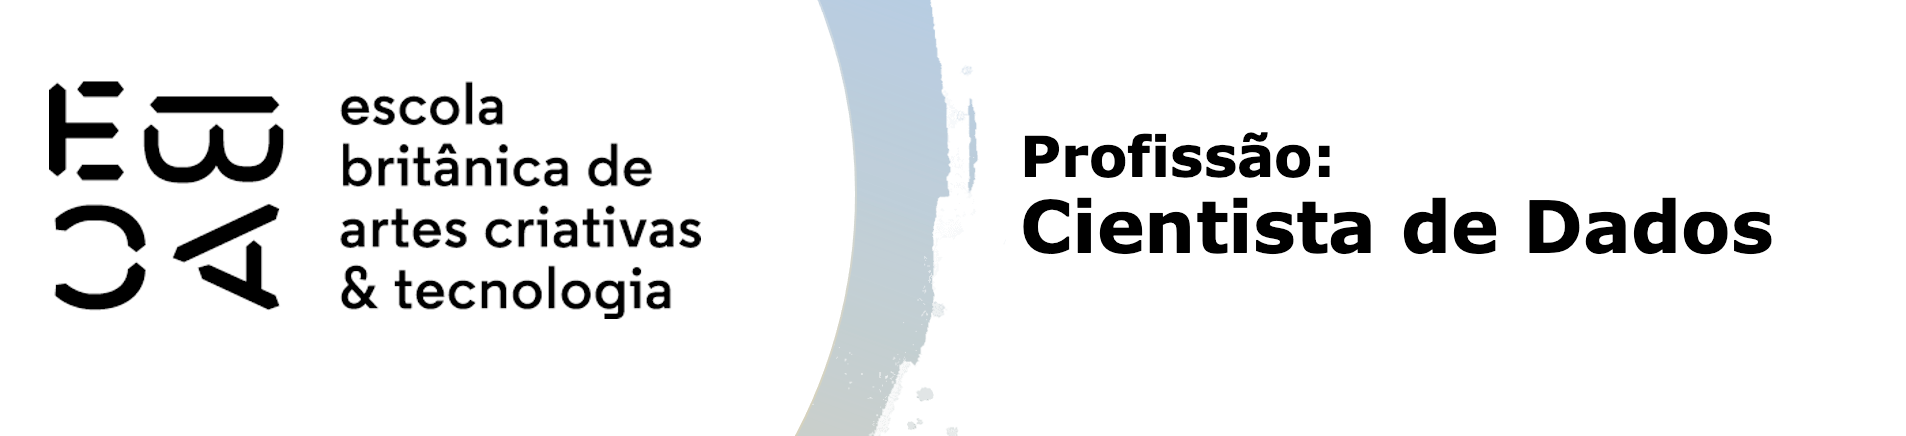

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [193]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from tqdm import tqdm

df = pd.read_csv('/Users/Meu Computador/anaconda3/EBAC/M 34 - Regressão III/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [194]:
# Preencher nulos em tempo_emprego com a média
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

# Apliquei a log em renda
df['renda_log'] = np.log(df['renda'])

# Convertendo para date time
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Extraindo os últimos 3 meses
ultima_data = df['data_ref'].max()
tres_meses = ultima_data - pd.DateOffset(months=3)

# Separando em treino e teste
train = df[df['data_ref'] <= tres_meses]
test = df[df['data_ref'] > tres_meses]

print("Treino:", train.shape)
print("Teste:", test.shape)

df.isnull().sum()

Treino: (600000, 15)
Teste: (150000, 15)


data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
renda_log                0
dtype: int64

In [195]:
# Criando as categorias de tempo_emprego em 20 quantis
new_test = test.copy()
new_test['tempo_emprego_cat'] = pd.qcut(test['tempo_emprego'], 
                                        q=20, 
                                        duplicates='drop')

new_test

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,tempo_emprego_cat
600000,2016-01-01,12946,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.746165,2.0,2137.61,7.667444,"(7.474, 7.746]"
600001,2016-01-01,8872,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35,9.538518,"(9.101, 10.471]"
600002,2016-01-01,16279,F,S,S,3,Assalariado,Médio,Casado,Casa,38,10.967123,5.0,11042.47,9.309504,"(10.471, 12.474]"
600003,2016-01-01,8158,M,S,S,3,Servidor público,Médio,Casado,Casa,35,5.553425,5.0,1333.82,7.195802,"(4.945, 5.759]"
600004,2016-01-01,9356,F,S,N,0,Assalariado,Médio,Viúvo,Casa,63,9.265753,1.0,17633.03,9.777529,"(9.101, 10.471]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40,7.982894,"(8.129, 9.101]"
749996,2016-03-01,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,7.746165,2.0,4084.37,8.314923,"(7.474, 7.746]"
749997,2016-03-01,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66,8.375551,"(10.471, 12.474]"
749998,2016-03-01,3024,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49,9.122546,"(8.129, 9.101]"


In [197]:
new_test.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'renda_log', 'tempo_emprego_cat'],
      dtype='object')

In [200]:
formula = (
    "renda_log ~ C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) "
    "+ C(qtd_filhos) + C(tipo_renda) + C(educacao) + C(estado_civil) "
    "+ C(tipo_residencia) + idade + tempo_emprego + C(qt_pessoas_residencia) "
    "+ C(tempo_emprego_cat)"
)

# Ajustando o modelo
model = smf.ols(formula=formula, data=new_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     3582.
Date:                Fri, 03 Oct 2025   Prob (F-statistic):               0.00
Time:                        09:57:56   Log-Likelihood:            -1.6619e+05
No. Observations:              150000   AIC:                         3.325e+05
Df Residuals:                  149948   BIC:                         3.330e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            6.5654      0.045    145.589      0.000       6.477       6.654
C(sexo)[T.M]                                                         0.1305      0.004     29.169      0.000       0.122       0.139
C(posse_de_veiculo)[T.S]                                             0.0092      0.004      2.158      0.031       0.001       0.018
C(posse_de_imovel)[T.S]                                              0.1882      0.004     45.161      0.000       0.180       0.196
C(qtd_filhos)[T.1]                                                  -0.1337      0.036     -3.679      0.000      -0.205      -0.062
C(qtd_filhos)[T.2]                                                  -0.2814      0.074     -3.796      0.000      -0.427      -0.136
C(qtd_filhos)[T.3]                                                  -0.7363      0.140     -5.253      0.000      -1.011      -0.462
C(qtd_filhos)[T.4]                                                   0.2584      0.185      1.395      0.163      -0.105       0.622
C(qtd_filhos)[T.5]                                                   0.1495      0.179      0.837      0.403      -0.201       0.499
C(qtd_filhos)[T.7]                                                   0.5398      0.076      7.140      0.000       0.392       0.688
C(qtd_filhos)[T.14]                                                 -0.0914      0.092     -0.995      0.320      -0.271       0.089
C(tipo_renda)[T.Bolsista]                                           -0.3321      0.087     -3.821      0.000      -0.502      -0.162
C(tipo_renda)[T.Empresário]                                          0.1480      0.005     30.902      0.000       0.139       0.157
C(tipo_renda)[T.Pensionista]                                        -0.2806      0.017    -16.233      0.000      -0.315      -0.247
C(tipo_renda)[T.Servidor público]                                    0.1209      0.007     17.136      0.000       0.107       0.135
C(educacao)[T.Médio]                                                -0.0044      0.018     -0.243      0.808      -0.040       0.031
C(educacao)[T.Pós graduação]                                         0.1035      0.059      1.746      0.081      -0.013       0.220
C(educacao)[T.Superior completo]                                     0.0963      0.018      5.298      0.000       0.061       0.132
C(educacao)[T.Superior incompleto]                                   0.0377      0.020      1.842      0.065      -0.002       0.078
C(estado_civil)[T.Separado]                                          0.2032      0.036      5.584      0.000       0.132       0.275
C(estado_civil)[T.Soltei

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

## Distribuição do modelo

Os dados se agregam em torno de um valor central, desenhando esse formato de ```sino```. Com isso, a priore, concluímos que há uma distribuição normal.

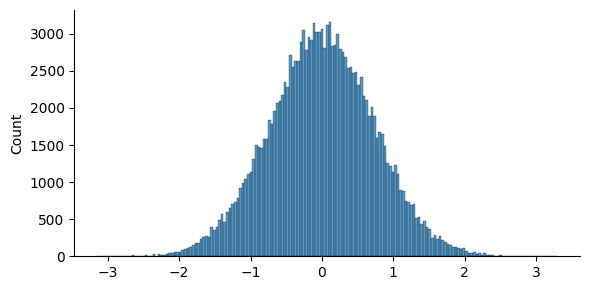

In [204]:
sns.displot(model.resid,
            height=3,
            aspect=2);

## Independência dos resíduos

    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência

In [206]:
# Previsões
y_pred = model.predict(new_test)

# Resíduos
residuo = new_test['renda_log'] - y_pred

# Novo dataframe com os valores inclusos
graf_res = new_test.copy()
graf_res['residuals'] = residuo
graf_res['predict'] = y_pred

In [207]:
# Função para criar gráfico para todas as variáveis;

variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
             'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
             'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']

def grafico_residuo(df, var):
    plt.figure(figsize=(8,6))
    
    if df[var].dtype == 'object' or df[var].dtype.name == 'category':
        # Boxplot para variáveis categóricas
        sns.boxplot(x=var, y='residuals', data=df)
    else:
        # Scatterplot para variáveis numéricas
        sns.scatterplot(x=var, y='residuals', data=df, alpha=0.5)
    
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(var)
    plt.ylabel('Resíduos')
    plt.title(f'Resíduos vs {var}')
    plt.show()

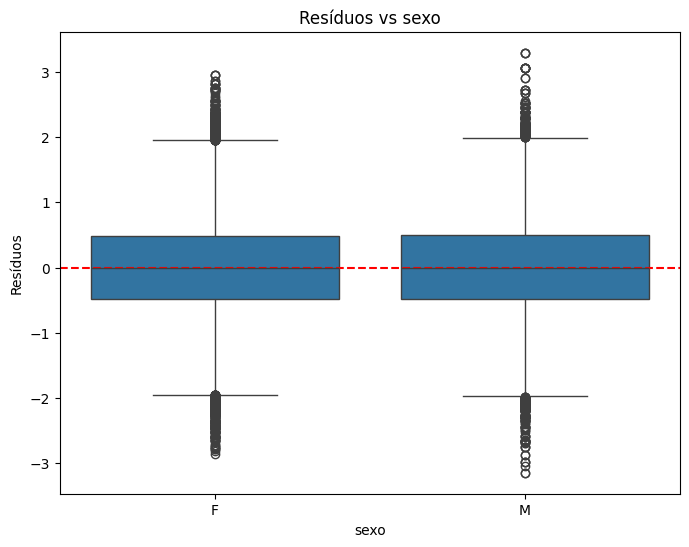

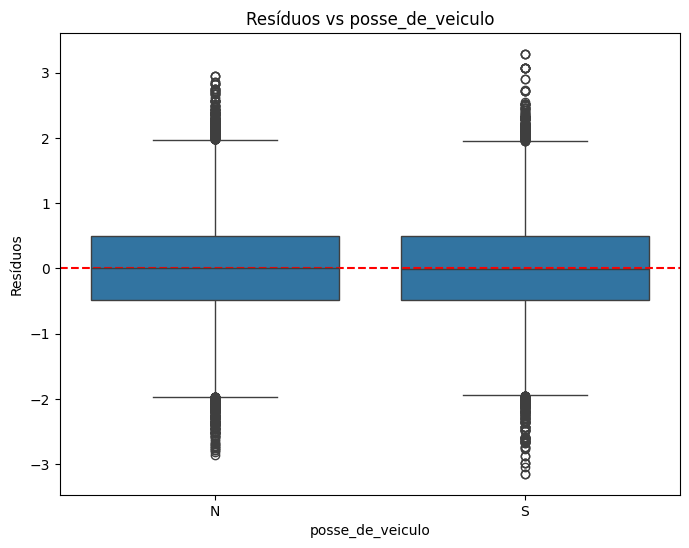

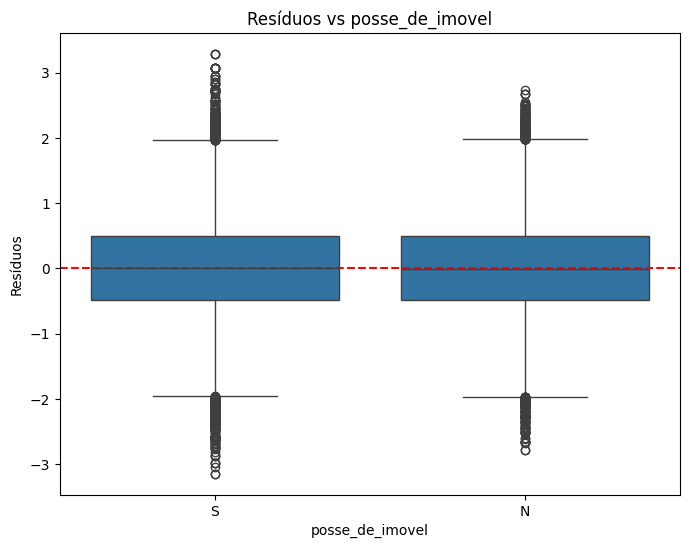

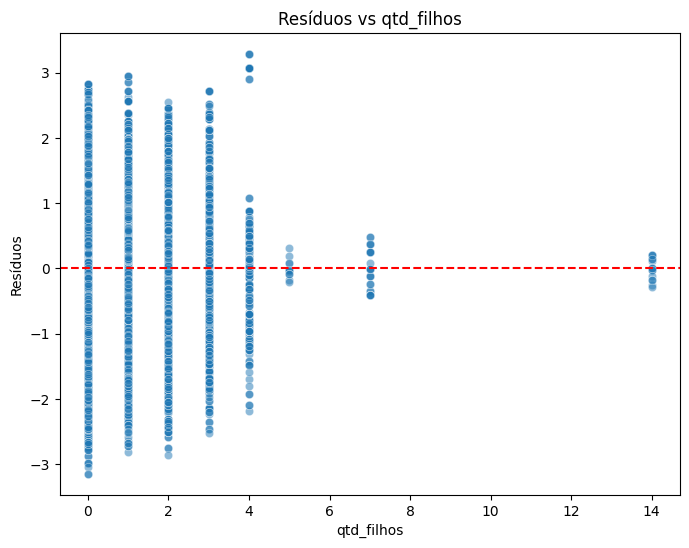

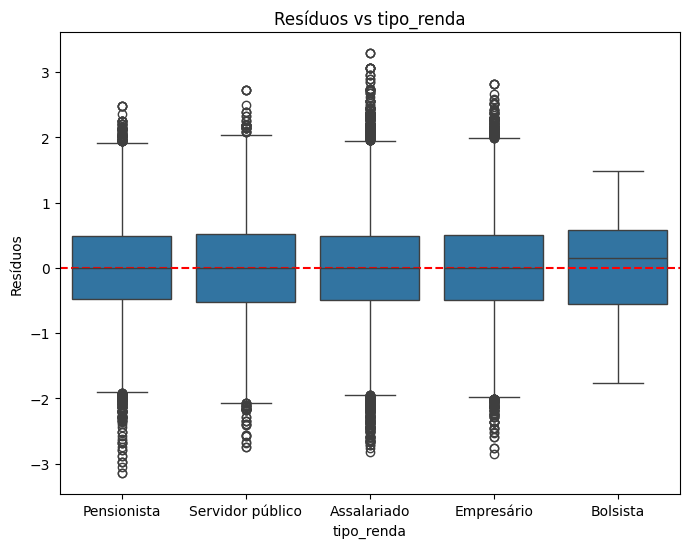

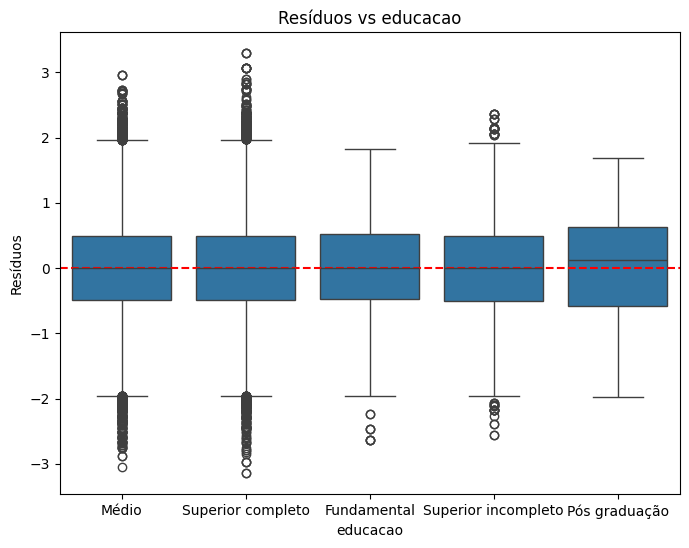

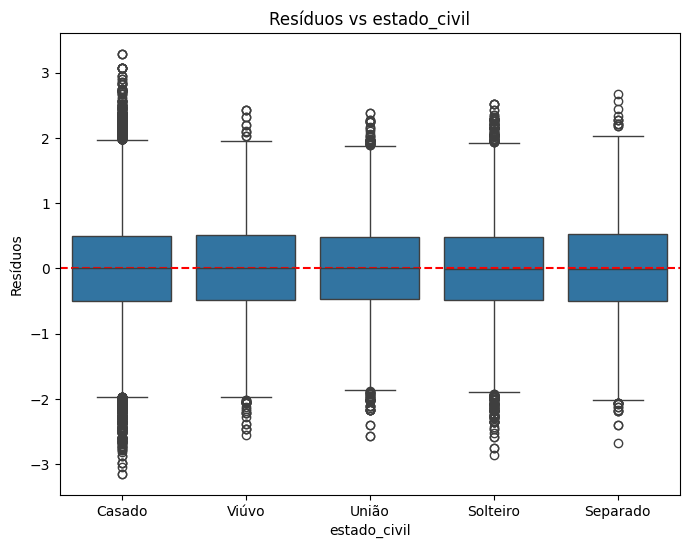

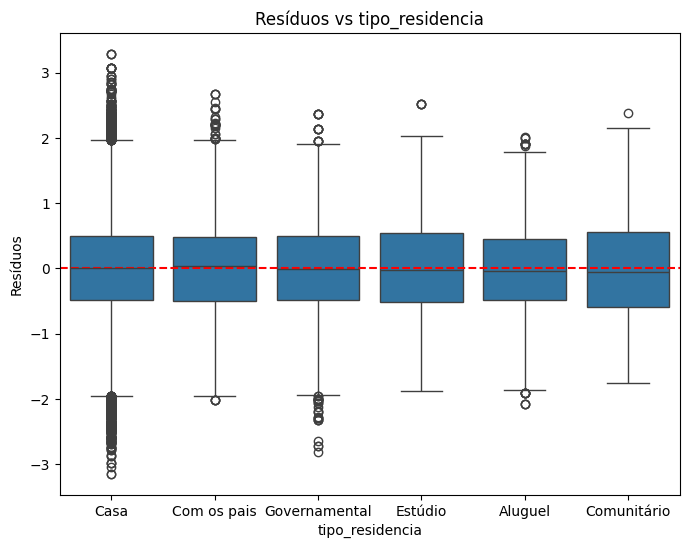

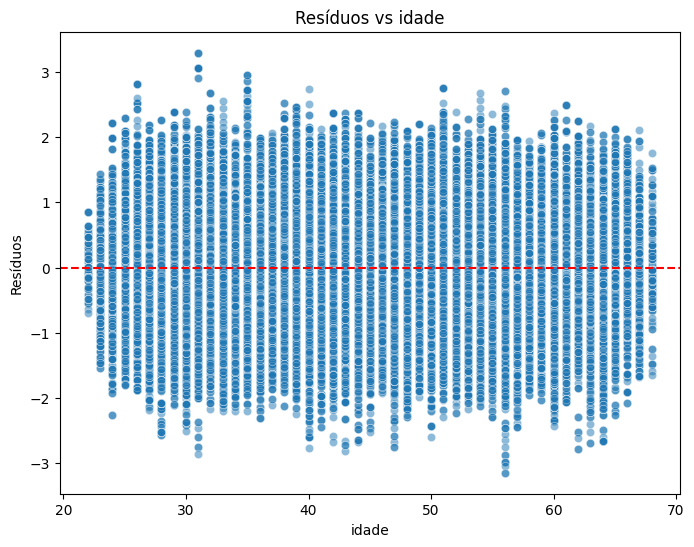

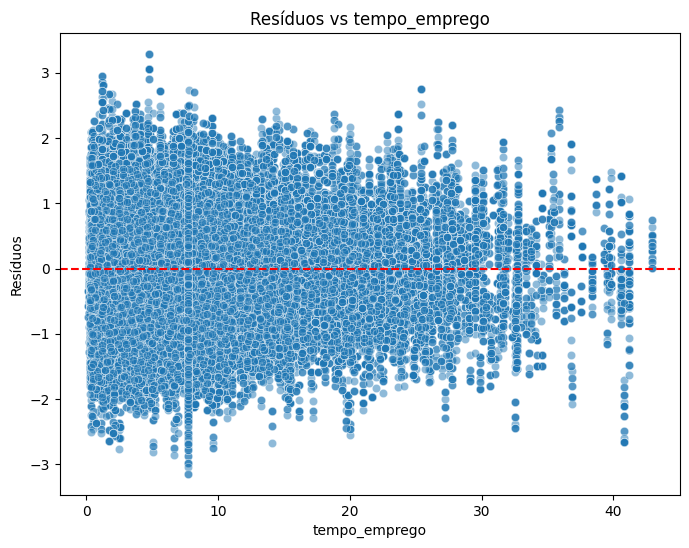

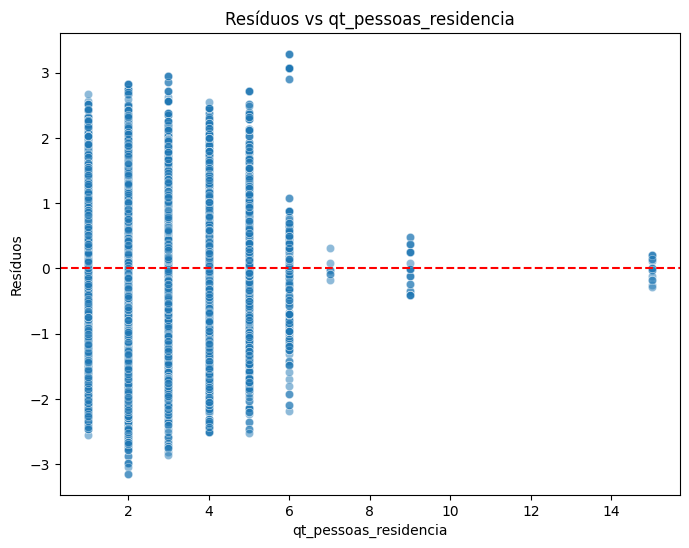

In [208]:
for v in variaveis:
    grafico_residuo(graf_res, v)

### Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo

De modo geral, as medianas dos resíduos ficam próximas do zero, indicando que não há forte viés por categoria. Entretanto, percebi que há muitos valores *-3* ou *3*, evidenciando possíveis **outliers**, que serão analisados e tratados posteriormente.

Dentro dessas variáveis, destaco duas que me chamaram a atenção:

1) ```tempo_emprego``` que apresentou um formato de funil, alertando para uma *heterocedasticidade* que será investigada.

2) ```tipo_renda``` mostra uma maior dispersão e mais outliers **positivos**, salientando uma *heterogeneidade*.



In [210]:
new_test['fitted'] = model.fittedvalues
new_test['residuals'] = model.resid
new_test['mes'] = new_test['data_ref'].dt.to_period('M')

media_residuos = new_test.groupby('mes')['residuals'].mean()
media_residuos

mes
2016-01    0.207221
2016-02   -0.020526
2016-03   -0.186694
Freq: M, Name: residuals, dtype: float64

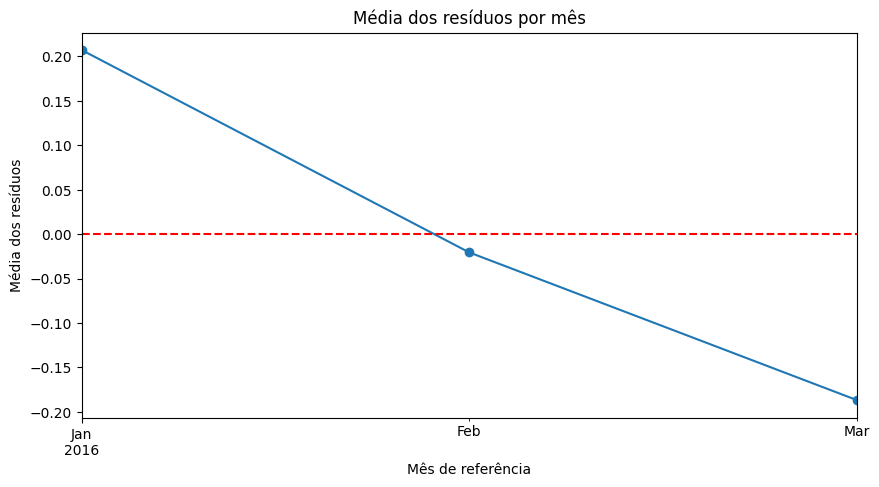

In [211]:
plt.figure(figsize=(10,5))
media_residuos.plot(marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Média dos resíduos por mês")
plt.ylabel("Média dos resíduos")
plt.xlabel("Mês de referência")
plt.show()

### Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência

- ```2016-01 → 0.207``` → resíduos médios positivos → o modelo tende a subestimar a renda nesse mês.

- ```2016-02 → -0.020``` → resíduos médios próximos de zero → sem viés aparente.

- ```2016-03 → -0.187``` → resíduos médios negativos → o modelo tende a superestimar a renda nesse mês.


Parece-me que o modelo ou trabalha com variação de sazonalidade e viés temporal ou não está captando muito bem os efeitos do tempo.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [216]:
influence = model.get_influence()
new_test['resid_student'] = influence.resid_studentized_internal

# Observações mais extremas
new_test[['resid_student']].assign(abs_resid=lambda x: x['resid_student'].abs()) \
       .sort_values('abs_resid', ascending=False).head(390)

,resid_student,abs_resid
618635,4.503392,4.503392
625367,4.503392,4.503392
621550,4.503392,4.503392
743490,-4.291704,4.291704
706776,-4.291704,4.291704
...,...,...
635564,-3.008316,3.008316
685452,-3.008088,3.008088
676661,-3.003564,3.003564
663252,-3.003564,3.003564


### Resid Student

Todos os valores acima estão acima de 3, ou seja, são **outliers claros** no modelo.
- ```Resíduos positivos```: modelo subestimou a renda
- ```Resíduos negativos```: modelo superestimou a renda

Mas nem todo outlier é necessariamente um problema, isso pode indicar que o modelo não explica bem certas combinações de variáveis.
O outlier torna-se crítico quando a **influência** (medida pelo *Cooks Distance*) for alta. Isso será analisado a seguir.

In [218]:
cooks_d = influence.cooks_distance[0]
n = len(new_test)
high_influence = np.sum(cooks_d > 4/n)
print(f"Pontos com alta influência: {high_influence} de {n}")

Pontos com alta influência: 5057 de 150000


In [219]:
influence = model.get_influence()
limite = 4 / n

resumo_influencia = pd.DataFrame({
    "cooks_distance": influence.cooks_distance[0],   # array com os valores
    "alavancagem": influence.hat_matrix_diag     # array com leverage
}, index=new_test.index)  # mantém o mesmo índice do dataset


influentes = resumo_influencia[resumo_influencia["cooks_distance"] > limite].sort_values(by='cooks_distance', ascending=False)
influentes

,cooks_distance,alavancagem
618635,0.001656,0.004472
621550,0.001656,0.004472
625367,0.001656,0.004472
743261,0.001515,0.013889
678213,0.001435,0.004472
...,...,...
733761,0.000027,0.000349
730952,0.000027,0.000223
639119,0.000027,0.000620
618919,0.000027,0.000620


### Influência

#### Cooks Distance
Mede a influência de cada ponto no ajuste do modelo. Quanto maior, mais influente.

#### Hat_diag (Alavancagem)
Mede quão “isolado” está o valor de X em relação aos demais. Vai de **0** a **1**, quanto mais próximo de 1, mais isolado ele está no espaço dos preditores. Se for maior, este é um ponto de ```outlier``` em *x*.


De modo geral, para apresentar perigo aos dados, é necessário que ambos estejam em valores altos.

- Um ponto pode ter alta **alavancagem**, mas não ser influente.
- Um ponto pode ter um *resíduo alto*, ou seja, um **cook distance** expressivo; mas se estiver isolado nos X, também não é influente.

---

### Análise das duas métricas

A fim de identificar as linhas onde **ambas as métricas** são expressivas, elaborei o código abaixo. Estipulei um limite para essas duas métricas:

```python
limite_cook = resumo_influencia["cooks_distance"].quantile(0.99)
limite_hat = resumo_influencia["alavancagem"].quantile(0.99)
```

Seguindo a lógica de que *uma métrica isolada não traz tanta informação*, apliquei no dataframe o filtro com os limites, onde a saída será os indivíduos que ultrapassam as **duas métricas**.

```python
suspeitos = resumo_influencia[
    (resumo_influencia["cooks_distance"] > limite_cook) &
    (resumo_influencia["alavancagem"] > limite_hat)
]
```

---

### Por que percentil 99?

Visto que o conjunto de dados possui 150 mil linhas, o percentil 99 vista capturar apenas os casos extremos, destacando os casos mais influentes de fato, sem se perder em milhares de *suspeitas leves*.

Veja que, anteriormente, foi identificado pouco mais de **5 mil** suspeitos. Este percentil visa filtrar dentro deste universo os casos potenciais, tornando a análise mais eficiente e assertiva.

In [221]:
# percentil 99 dos dois indicadores
limite_cook = resumo_influencia["cooks_distance"].quantile(0.99)
limite_hat = resumo_influencia["alavancagem"].quantile(0.99)

suspeitos = resumo_influencia[
    (resumo_influencia["cooks_distance"] > limite_cook) &
    (resumo_influencia["alavancagem"] > limite_hat)
]

print("Observações suspeitas:", suspeitos.shape[0])
print(suspeitos.sort_values(["cooks_distance", "alavancagem"], ascending=False).head(15))

Observações suspeitas: 507
        cooks_distance  alavancagem
618635        0.001656     0.004472
621550        0.001656     0.004472
625367        0.001656     0.004472
743261        0.001515     0.013889
656591        0.001435     0.004472
657138        0.001435     0.004472
675381        0.001435     0.004472
678213        0.001435     0.004472
687153        0.001435     0.004472
697994        0.001435     0.004472
699120        0.001435     0.004472
719598        0.001284     0.004472
737818        0.001284     0.004472
656682        0.001245     0.013889
678068        0.001245     0.013889


### Suspeitos

Neste dataframe estão os **suspeitos**, ou seja, aqueles que ultrapassaram o limite estabelecido para ```cooks_distance``` e ```alavancagem```.

Com isso em mãos, conseguimos analisar as variáveis de cada indivíduo.

In [225]:
new_test.loc[suspeitos.index]

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,tempo_emprego_cat,fitted,residuals,mes,resid_student
600092,2016-01-01,2099,M,N,S,2,Assalariado,Médio,Solteiro,Casa,31,11.010959,3.0,15607.71,9.655520,"(10.471, 12.474]",8.608800,1.046721,2016-01,1.429625
600427,2016-01-01,16578,F,N,N,0,Assalariado,Médio,Viúvo,Comunitário,54,1.600000,1.0,3994.35,8.292636,"(1.468, 2.099]",7.080845,1.211791,2016-01,1.655124
600448,2016-01-01,14409,F,N,S,2,Servidor público,Médio,Casado,Comunitário,38,4.868493,4.0,575.43,6.355118,"(4.304, 4.945]",7.684943,-1.329825,2016-01,-1.816324
600672,2016-01-01,7419,F,N,N,2,Assalariado,Superior completo,Separado,Governamental,27,1.632877,3.0,4352.69,8.378549,"(1.468, 2.099]",7.210298,1.168252,2016-01,1.595791
600706,2016-01-01,6094,M,S,S,4,Assalariado,Superior completo,Casado,Casa,31,4.750685,6.0,1413.85,7.254072,"(4.304, 4.945]",8.111638,-0.857566,2016-01,-1.172828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749128,2016-03-01,15168,M,S,S,0,Assalariado,Pós graduação,Casado,Casa,61,0.534247,2.0,648.53,6.474708,"(0.11699999999999999, 0.827]",7.456082,-0.981373,2016-03,-1.343234
749209,2016-03-01,10616,F,N,N,2,Assalariado,Superior completo,Separado,Casa,39,0.515068,3.0,220.73,5.396940,"(0.11699999999999999, 0.827]",7.094672,-1.697732,2016-03,-2.318757
749371,2016-03-01,250,M,S,N,1,Assalariado,Superior completo,Separado,Comunitário,32,3.109589,2.0,513.26,6.240783,"(2.912, 3.636]",7.465989,-1.225207,2016-03,-1.673484
749460,2016-03-01,7983,F,N,S,1,Assalariado,Pós graduação,Solteiro,Casa,34,7.586301,2.0,12453.97,9.429795,"(7.474, 7.746]",8.140451,1.289343,2016-03,1.764954


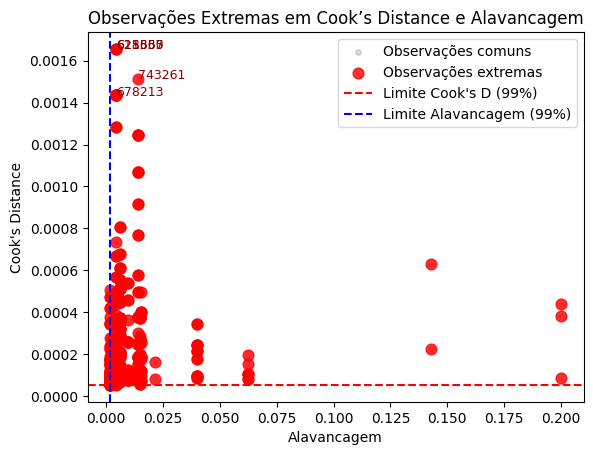

In [163]:
extremos = (resumo_influencia['cooks_distance'] > limite_cook) | (resumo_influencia['alavancagem'] > limite_hat)

# 1. Plotar todos os pontos com transparência
plt.scatter(suspeitos['alavancagem'], suspeitos['cooks_distance'], 
            s=15, alpha=0.3, color="gray", label="Observações comuns")

# 2. Destacar os casos extremos
plt.scatter(suspeitos.loc[extremos, 'alavancagem'], 
            suspeitos.loc[extremos, 'cooks_distance'], 
            s=60, color="red", alpha=0.8, label="Observações extremas")

# 3. Adicionar linhas de corte
plt.axhline(y=limite_cook, color="red", linestyle="--", label="Limite Cook's D (99%)")
plt.axvline(x=limite_hat, color="blue", linestyle="--", label="Limite Alavancagem (99%)")

# 4. (Opcional) Adicionar labels nos top 5 casos extremos
top5 = suspeitos.sort_values(by="cooks_distance", ascending=False).head(5)
for idx, row in top5.iterrows():
    plt.text(row['alavancagem'], row['cooks_distance'], str(idx), 
             fontsize=9, color="darkred")

plt.xlabel("Alavancagem")
plt.ylabel("Cook's Distance")
plt.title("Observações Extremas em Cook’s Distance e Alavancagem")
plt.legend()
plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [272]:
# Lista das colunas para transformar em dummies
cols_para_dummies = ['sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos']

# Cria dummies só para essas colunas
new_test_encoded = pd.get_dummies(new_test, columns=cols_para_dummies, drop_first=True)
new_test_encoded = new_test_encoded.drop(columns=['data_ref', 'index', 'mes', 'renda', 'fitted', 'residuals', 'resid_student'])

# Seleciona as colunas do tipo bool
bool_cols = new_test_encoded.select_dtypes(include="bool").columns

# Converte cada uma com map
for col in bool_cols:
    new_test_encoded[col] = new_test_encoded[col].map({False: 0, True: 1})

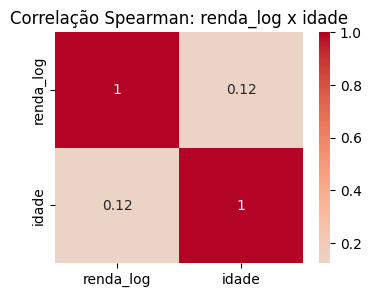

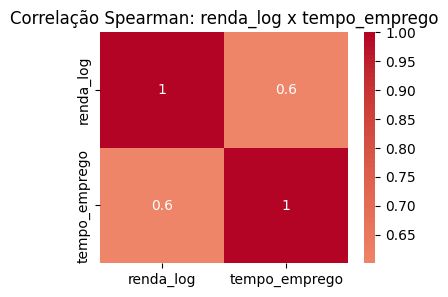

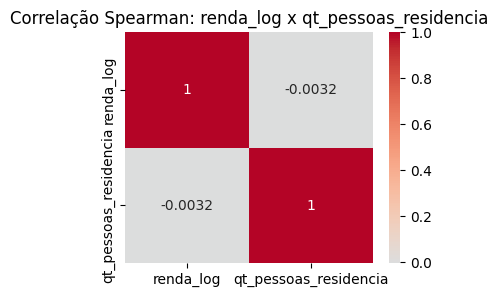

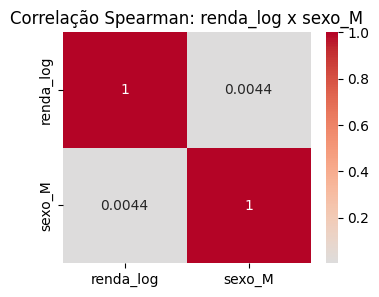

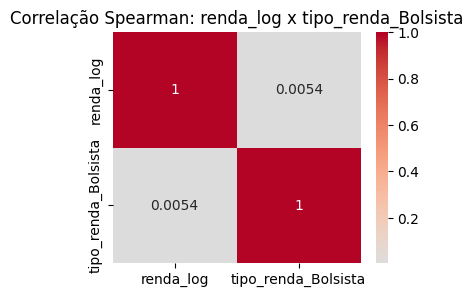

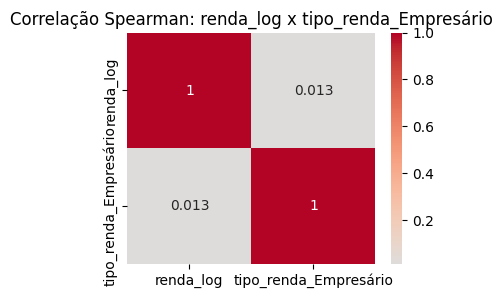

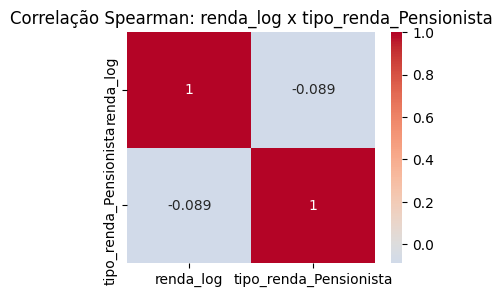

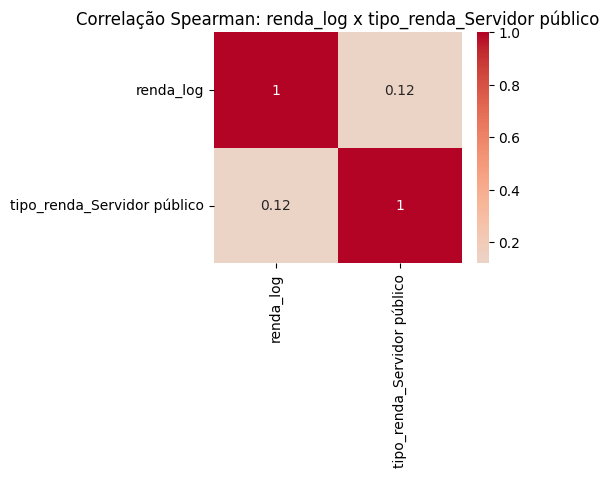

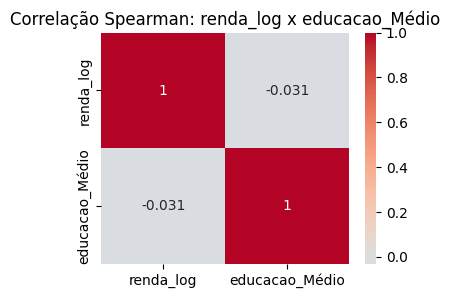

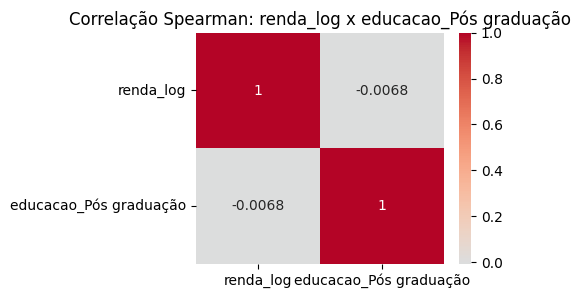

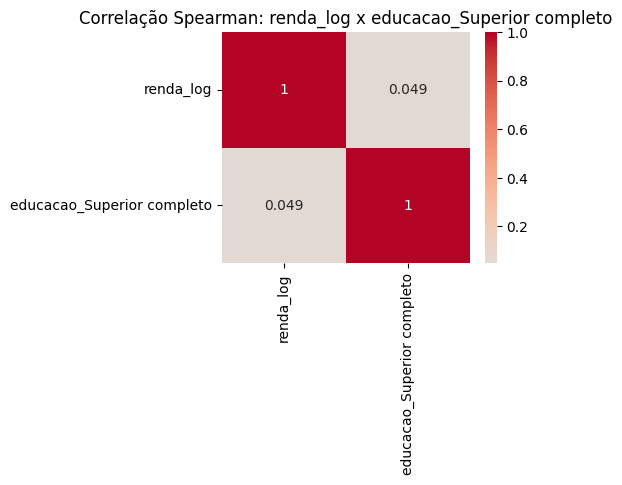

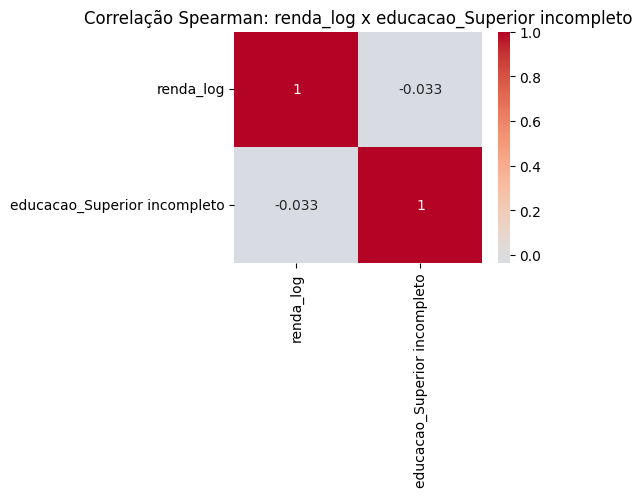

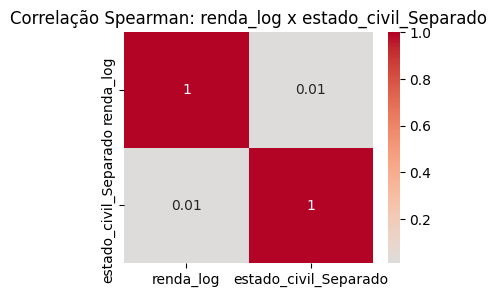

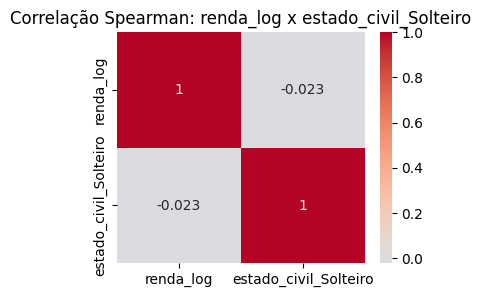

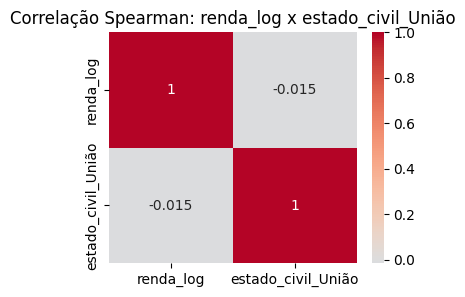

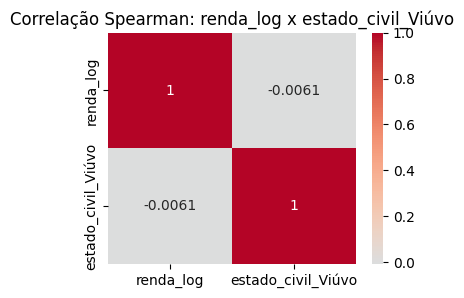

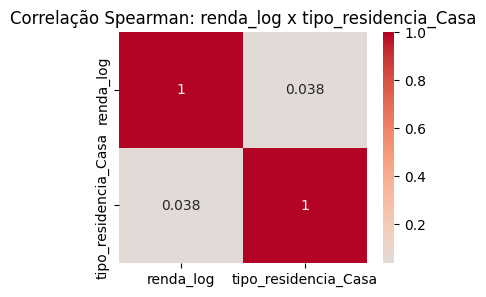

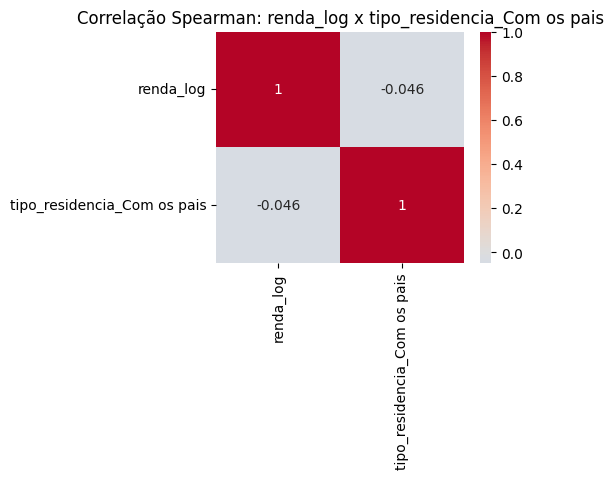

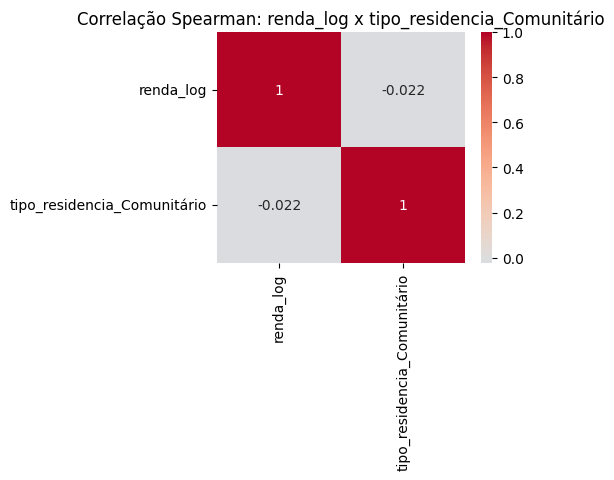

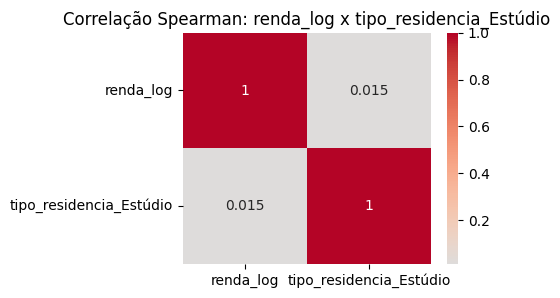

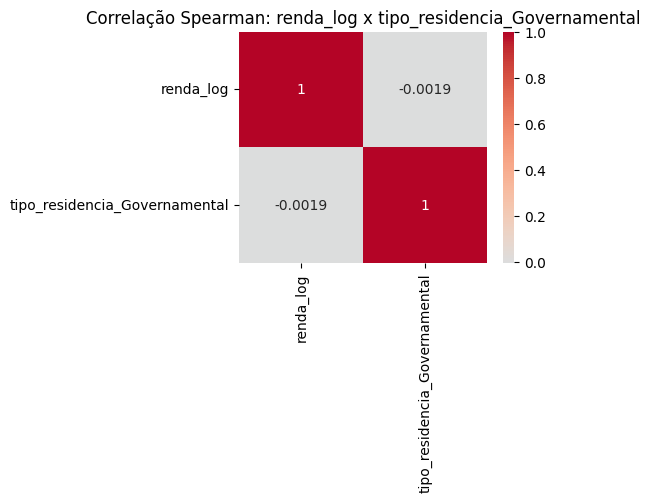

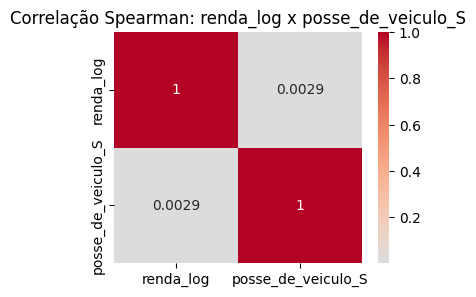

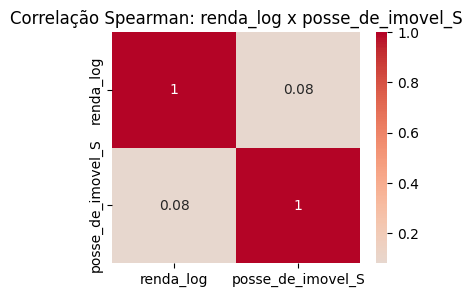

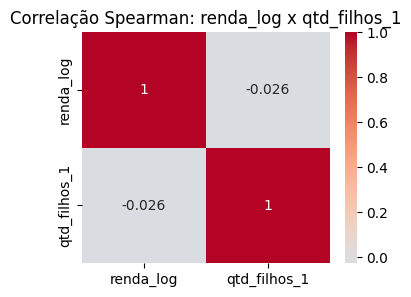

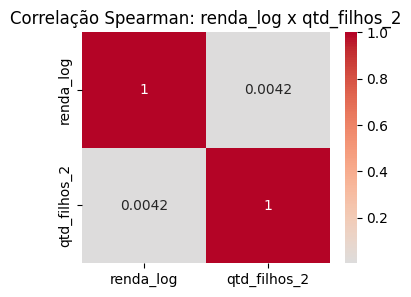

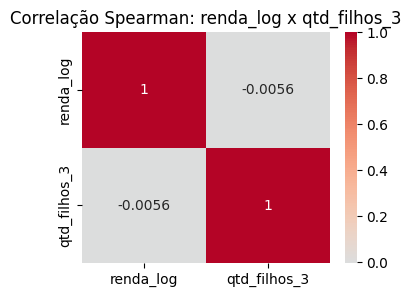

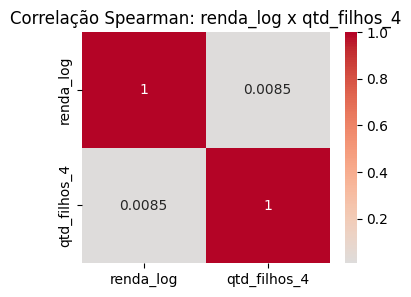

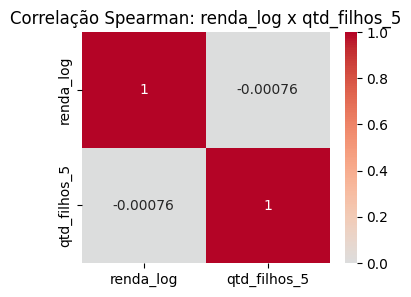

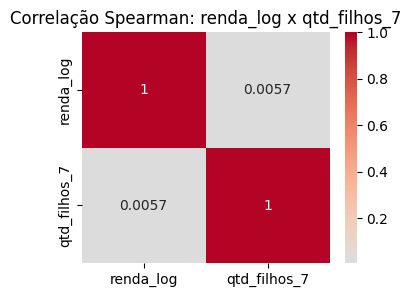

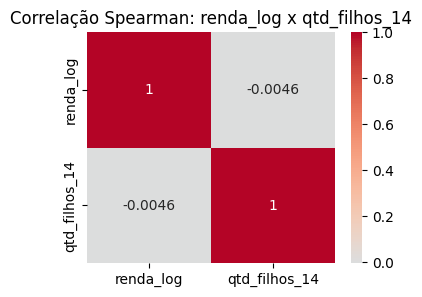

In [276]:
num_cols = new_test_encoded.select_dtypes(include=['number']).columns
num_cols = [col for col in num_cols if col != 'renda_log']

for col in num_cols:
    # Cria DataFrame temporário com 'renda_log' e a variável atual
    df_temp = new_test_encoded[['renda_log', col]]
    
    # Calcula correlação Spearman
    corr = df_temp.corr(method='spearman')
    
    # Plot
    plt.figure(figsize=(4,3))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f"Correlação Spearman: renda_log x {col}")
    plt.show()

### Matriz de Correlação

| Valor       | Interpretação                                                   |
|------------|-----------------------------------------------------------------|
| 1          | Correlação positiva perfeita (uma aumenta, a outra sempre aumenta) |
| 0.7–0.9    | Correlação forte positiva                                       |
| 0.4–0.6    | Correlação moderada positiva                                    |
| 0.1–0.3    | Correlação fraca positiva                                       |
| 0          | Sem correlação monotônica                                       |
| -0.1 a -0.3| Correlação fraca negativa                                       |
| -0.4 a -0.6| Correlação moderada negativa                                    |
| -0.7 a -0.9| Correlação forte negativa                                       |
| -1         | Correlação negativa perfeita (uma aumenta, a outra sempre diminui) |


In [300]:
# Seleciona colunas numéricas
num_cols = new_test_encoded.select_dtypes(include=['number']).columns

# Inicializa dicionário
corr_renda = {}

# Loop: calcula Spearman entre 'renda_log' e cada coluna numérica
for col in num_cols:
    if col != 'renda_log':
        corr_renda[col] = new_test_encoded['renda_log'].corr(new_test_encoded[col], method='spearman')

# Converte para DataFrame
corr_renda_df = pd.DataFrame.from_dict(corr_renda, orient='index', columns=['correlação'])

# Ordena pela magnitude da correlação
corr_renda_df = corr_renda_df.sort_values(by='correlação', ascending=False)

In [304]:
corr_renda_log = pd.Series({
    "tempo_emprego": 0.600791,
    "idade": 0.123072,
    "tipo_renda_Servidor público": 0.120360,
    "posse_de_imovel_S": 0.080226,
    "educacao_Superior completo": 0.048848,
    "tipo_residencia_Casa": 0.038186,
    "tipo_residencia_Estúdio": 0.014872,
    "tipo_renda_Empresário": 0.013164,
    "estado_civil_Separado": 0.010371,
    "qtd_filhos_4": 0.008531,
    "qtd_filhos_7": 0.005748,
    "tipo_renda_Bolsista": 0.005375,
    "sexo_M": 0.004393,
    "qtd_filhos_2": 0.004187,
    "posse_de_veiculo_S": 0.002884,
    "qtd_filhos_5": -0.000756,
    "tipo_residencia_Governamental": -0.001923,
    "qt_pessoas_residencia": -0.003239,
    "qtd_filhos_14": -0.004630,
    "qtd_filhos_3": -0.005550,
    "estado_civil_Viúvo": -0.006096,
    "educacao_Pós graduação": -0.006755,
    "estado_civil_União": -0.014698,
    "tipo_residencia_Comunitário": -0.022150,
    "estado_civil_Solteiro": -0.022533,
    "qtd_filhos_1": -0.025695,
    "educacao_Médio": -0.030996,
    "educacao_Superior incompleto": -0.032969,
    "tipo_residencia_Com os pais": -0.046270,
    "tipo_renda_Pensionista": -0.089147
})

# Transforma em DataFrame
corr_df = corr_renda_log.reset_index()
corr_df.columns = ['variavel', 'correlação']

# Classificar a força da correlação
def classificar_corr(x):
    if x >= 0.7:
        return "Forte positiva"
    elif x >= 0.4:
        return "Moderada positiva"
    elif x >= 0.1:
        return "Fraca positiva"
    elif x <= -0.7:
        return "Forte negativa"
    elif x <= -0.4:
        return "Moderada negativa"
    elif x <= -0.1:
        return "Fraca negativa"
    else:
        return "Sem correlação"

corr_df['força'] = corr_df['correlação'].apply(classificar_corr)

# Ordena pelo valor absoluto da correlação
corr_df['abs_corr'] = corr_df['correlação'].abs()
corr_df = corr_df.sort_values(by='abs_corr', ascending=False).drop(columns=['abs_corr'])

# Visualiza
corr_df

,variavel,correlação,força
0,tempo_emprego,0.600791,Moderada positiva
1,idade,0.123072,Fraca positiva
2,tipo_renda_Servidor público,0.120360,Fraca positiva
29,tipo_renda_Pensionista,-0.089147,Sem correlação
3,posse_de_imovel_S,0.080226,Sem correlação
4,educacao_Superior completo,0.048848,Sem correlação
28,tipo_residencia_Com os pais,-0.046270,Sem correlação
5,tipo_residencia_Casa,0.038186,Sem correlação
27,educacao_Superior incompleto,-0.032969,Sem correlação
26,educacao_Médio,-0.030996,Sem correlação


### VIF

Os valores do VIF, para algumas variáveis, estão extremamente altos. Variáveis como ```qt_pessoas_residencia```, ```tipo_residencia_Casa``` e ```educacao_Médio``` estão com valores altíssimos. Mas por que isso aconteceu?

Acontece porque existem alta correlações entre essas variáveis. Isso causa VIFs altíssimos, porque o VIF mede quanto uma variável pode ser prevista pelas outras. Quanto mais linearmente dependente, maior o VIF.

Vamos mitigar esses valores no ajuste final.

In [329]:
# Seleciona apenas variáveis numéricas (excluindo a target)
X = new_test_encoded[num_cols].drop(columns=['renda_log'])

# Calcula VIF
vif_data = pd.DataFrame()
vif_data["variavel"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

# Ordena pelo VIF
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data

,variavel,VIF
2,qt_pessoas_residencia,241.111599
16,tipo_residencia_Casa,61.749376
8,educacao_Médio,43.754088
10,educacao_Superior completo,38.357344
0,idade,35.301752
24,qtd_filhos_2,18.159781
23,qtd_filhos_1,11.154651
13,estado_civil_Solteiro,5.824383
25,qtd_filhos_3,5.416773
11,educacao_Superior incompleto,4.324836


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

---

### PCA + Componentes Ortogonais
Para mitigar esses valores, apliquei o **PCA** para transformar variáveis correlacionadas em ```componentes ortogonais```. Ao realizar essa substituição, todos os valores diminuiram (em alguma medida).

### Explicando o código
1) Agrupei variáveis correlacionadas. Analisando o dataframe sem PCA, percebi que as variáveis relacionadas a filhos, educação e residência possuiam VIF altíssimos.

```python
filhos_cols = ['qt_pessoas_residencia', 'qtd_filhos_1', 'qtd_filhos_2', 
               'qtd_filhos_3', 'qtd_filhos_4', 'qtd_filhos_5', 'qtd_filhos_7', 
               'qtd_filhos_14']

educ_cols = ['educacao_Médio', 'educacao_Superior completo', 'educacao_Superior incompleto', 'educacao_Pós graduação']

resid_cols = ['tipo_residencia_Casa', 'tipo_residencia_Com os pais', 'tipo_residencia_Estúdio', 
              'tipo_residencia_Comunitário', 'tipo_residencia_Governamental']

idade_tempo_cols = ['idade', 'tempo_emprego']
```

2) Apliquei PCA separadamente em cada grupo, gerando componentes ortogonais;

```python
filhos_pca = aplicar_pca(new_test_encoded, filhos_cols, n_components=2, prefix='filhos_PC')
educ_pca = aplicar_pca(new_test_encoded, educ_cols, n_components=2, prefix='educ_PC')
resid_pca = aplicar_pca(new_test_encoded, resid_cols, n_components=2, prefix='resid_PC')
idade_pca = aplicar_pca(new_test_encoded, idade_tempo_cols, n_components=1, prefix='idade_PC')
```

3) Substitui as variáveis originais pelos PCs, mantendo interpretabilidade;

```python
cols_para_remover = filhos_cols + educ_cols + resid_cols
new_test_pca = pd.concat([
    new_test_encoded.drop(columns=cols_para_remover),
    filhos_pca, educ_pca, resid_pca
], axis=1)
```

4) Converti booleanos restantes para 0/1;

```python
bool_cols = new_test_pca.select_dtypes(include=['bool']).columns
new_test_pca[bool_cols] = new_test_pca[bool_cols].astype(int)
```

5) Calculei o VIF das variáveis finais.

```python
vif_data_pca = pd.DataFrame()
vif_data_pca['variavel'] = X_vif.columns
vif_data_pca['VIF'] = [vif(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data_pca = vif_data_pca.sort_values(by='VIF', ascending=False)
```

### Resultado
- VIFs das variáveis originais muito altas (idade, educação, residência, filhos) caem drasticamente.
- Eliminei quase toda a multicolinearidade do dataset.

In [381]:
# Definir grupos de variáveis correlacionadas
filhos_cols = ['qt_pessoas_residencia', 'qtd_filhos_1', 'qtd_filhos_2', 
               'qtd_filhos_3', 'qtd_filhos_4', 'qtd_filhos_5', 'qtd_filhos_7', 
               'qtd_filhos_14']

educ_cols = ['educacao_Médio', 'educacao_Superior completo', 'educacao_Superior incompleto', 'educacao_Pós graduação']

resid_cols = ['tipo_residencia_Casa', 'tipo_residencia_Com os pais', 'tipo_residencia_Estúdio', 
              'tipo_residencia_Comunitário', 'tipo_residencia_Governamental']

idade_tempo_cols = ['idade', 'tempo_emprego']

# Função para aplicar PCA em cada grupo 
def aplicar_pca(df, cols, n_components=2, prefix='PC'):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[cols])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    pca_cols = [f"{prefix}{i+1}" for i in range(n_components)]
    df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)
    return df_pca

# Aplica PCA em cada grupo
filhos_pca = aplicar_pca(new_test_encoded, filhos_cols, n_components=2, prefix='filhos_PC')
educ_pca = aplicar_pca(new_test_encoded, educ_cols, n_components=2, prefix='educ_PC')
resid_pca = aplicar_pca(new_test_encoded, resid_cols, n_components=2, prefix='resid_PC')
idade_pca = aplicar_pca(new_test_encoded, idade_tempo_cols, n_components=1, prefix='idade_PC')  

# Cria novo dataframe substituindo as variáveis originais 
cols_para_remover = filhos_cols + educ_cols + resid_cols + idade_tempo_cols
new_test_pca = pd.concat([
    new_test_encoded.drop(columns=cols_para_remover),
    filhos_pca, educ_pca, resid_pca, idade_pca
], axis=1)

# Converte booleanos restantes para 0/1 
bool_cols = new_test_pca.select_dtypes(include=['bool']).columns
new_test_pca[bool_cols] = new_test_pca[bool_cols].astype(int)

# Seleciona variáveis numéricas para VIF
X_vif = new_test_pca.select_dtypes(include=['number']).drop(columns=['renda_log'])

# Calcula o VIF 
vif_data_pca = pd.DataFrame()
vif_data_pca['variavel'] = X_vif.columns
vif_data_pca['VIF'] = [vif(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data_pca = vif_data_pca.sort_values(by='VIF', ascending=False)

vif_data_pca

,variavel,VIF
10,posse_de_imovel_S,2.057348
9,posse_de_veiculo_S,1.791493
0,sexo_M,1.689167
3,tipo_renda_Pensionista,1.487951
17,idade_PC1,1.357437
2,tipo_renda_Empresário,1.324839
11,filhos_PC1,1.301803
6,estado_civil_Solteiro,1.288396
8,estado_civil_Viúvo,1.144632
4,tipo_renda_Servidor público,1.123262


In [383]:
# Renomear colunas para evitar espaços
new_test_pca.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

X_vars = new_test_pca.drop(columns=['renda_log']).columns
formula = 'renda_log ~ ' + ' + '.join(X_vars)

# Ajuste do modelo
model_pca = smf.ols(formula=formula, data=new_test_pca).fit()

# Mostrar resultados detalhados
depois_pca = model_pca.summary()
antes_pca = model.summary()

### Tabela do OLS Regression Results

#### Antes do PCA
- **F-statistic**: 3582
- **Df Model**:: 51
- **R²**:: 0.549

#### Depois do PCA
- **F-statistic**:: 5067
- **Df Model**:: 36
- **R²**:: 0.537

A redução da multicolinearidade por meio do **PCA** melhorou o **F-statistic**, tornando o modelo mais estatisticamente robusto, com coeficientes mais confiáveis, menor ruído e menos redundância entre variáveis.

Embora o **R²** tenha diminuído ligeiramente, a manutenção do modelo é justificável, considerando a maior confiabilidade dos resultados.

Para aumentar especificamente o R² do OLS, seria necessário:
- Adicionar novas variáveis que expliquem melhor a **renda_log**;
- Avaliar modelos não-lineares, como **Random Forest** ou **Gradient Boosting**, que capturam interações complexas entre variáveis.

Para os objetivos desta análise, o principal resultado foi alcançado: reduzir a multicolinearidade, mantendo a confiabilidade e interpretabilidade do modelo.

In [385]:
depois_pca.tables[0]

Dep. Variable:,renda_log,R-squared:,0.537
Model:,OLS,Adj. R-squared:,0.537
Method:,Least Squares,F-statistic:,4977.
Date:,"Fri, 03 Oct 2025",Prob (F-statistic):,0.00
Time:,11:42:08,Log-Likelihood:,-1.6814e+05
No. Observations:,150000,AIC:,3.363e+05
Df Residuals:,149964,BIC:,3.367e+05
Df Model:,35,,
Covariance Type:,nonrobust,,


In [387]:
antes_pca.tables[0]

Dep. Variable:,renda_log,R-squared:,0.549
Model:,OLS,Adj. R-squared:,0.549
Method:,Least Squares,F-statistic:,3582.
Date:,"Fri, 03 Oct 2025",Prob (F-statistic):,0.00
Time:,11:42:08,Log-Likelihood:,-1.6619e+05
No. Observations:,150000,AIC:,3.325e+05
Df Residuals:,149948,BIC:,3.330e+05
Df Model:,51,,
Covariance Type:,nonrobust,,
